In [13]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib.pyplot as plt
import MESS
import numpy as np
import os
import pandas as pd

from IPython.display import display

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load and curate the snail pi and trait data
Takes a little bit of work since there are some mismatches between naming schemes and some samples in one set and not in the other, but eventually we get there.

,pi,trait
AL_N_sp1,0.008677,-0.754505
WF_N_elaeodes,0.010133,0.069074


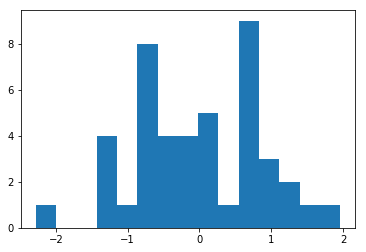

In [10]:
sn_dir = "/home/iovercast/Continuosity/MESS/empirical_data/Galapagos_snails/"
sn_pis = pd.read_csv(sn_dir + "snail.pis", sep=",", header=0, index_col=0)
sn_pis.columns = ['pi']

## Insert the "_N_" in the species name for all species for agreement with
## names in the trait table
sn_pis.index = [x.replace("_", "_N_") for x in sn_pis.index]

sn_traits = pd.read_csv(sn_dir + "Naesiotus_Shell_measurements.csv", sep=",", index_col=0, header=0)
## Convert width and height to volume of a cone (roughly) 1/3*pi*r^2*h
sn_traits["ShellVolume"] = (np.pi * (sn_traits["ShellWidth"]/2)**2 * sn_traits["ShellHeight"])/3

## Fix names that don't agree between pis and traits
sn_traits.rename(index={'PI_N_nov_sp':'PI_N_nov'},inplace=True)
sn_traits.rename(index={'SC_N_cf_reibischi':'SC_N_reibischi'},inplace=True)
sn_traits.rename(index={'FA_N_perrus_sp1':'FA_N_perrus'},inplace=True)

## Finally drop a couple species that are in one and not the other
sn_pis = sn_pis.drop("PI_N_pinzonopsis")
sn_traits = sn_traits.drop(['PI_N_pinzonensis', 'FA_N_perrus_sp2'])

## And drop a duplicate species name from the trait index "SC_N_reibischi"
sn_traits = sn_traits[sn_traits["ID on Phylo"] != 'SC_N_cf_reibischi_SC14_141_5']

## Join pi and trait DFs
sn_df = pd.concat([sn_pis, sn_traits], axis=1, sort=False)
sn_df = sn_df.drop(["ID on Phylo", "ShellHeight", "ShellWidth"], axis=1)

## Log and zero center ShellVolume and rename the column as 'trait'
sn_df["ShellVolume"] = np.log(sn_df["ShellVolume"])
sn_df["ShellVolume"] = sn_df["ShellVolume"] - np.mean(sn_df["ShellVolume"])
sn_df.columns = ["pi", "trait"]

## Verify roughly normally distributed
plt.hist(sn_df["trait"], bins=15)

## Write to file to save
sn_df.to_csv(sn_dir + "snail_df.csv")
display(sn_df[:2])

## Split the full data to dataframes per island
We will split samples to 3 islands which have the most samples/species: Isabela (0.3-0.6My), San Cristobal (3.2My), and Santa Cruz (1.8My):

    CA: Cerro Azul volcano on Isabela
    SN: Sierra Negra volcano on Isabela
    DA: Darwin volcano on Isabela
    AL: Alcedo volcano on Isabela
    WF: Wolf volcano on Isabela

    SL: San Cristobal

    SC: Santa Cruz


In [29]:
sl_species = [x for x in sn_df.index if "SL" in x]
sc_species = [x for x in sn_df.index if "SC" in x]
is_species = [x for x in sn_df.index if x.split("_")[0] in ["CA", "SN", "DA", "AL", "WF"]]
sl_df = sn_df.loc[sl_species, :]
sc_df = sn_df.loc[sc_species, :]
is_df = sn_df.loc[is_species, :]
print("N species - ")
for n, df in zip(["San_Cristobal", "Santa_Cruz", "Isabela"],\
                [sl_df, sc_df, is_df]):
    print("\t{}  \t{}".format(n, len(df)))

## Get metacommunity trait distribution (pool all traits for all sites)
metacommunity_traits = sn_df["trait"].unique()

N species - 
	San_Cristobal  	7
	Santa_Cruz  	11
	Isabela  	10


44

## Test models combining all data for all islands

In [101]:
simfile = "/home/isaac/Continuosity/MESS/analysis/full-parameter-estimation/SIMOUT.txt"
rgr = MESS.inference.Classifier(empirical_df=sn_df, simfile=simfile, algorithm="rf",\
                               metacommunity_traits=metacommunity_traits)
rgr.predict(select_features=True, param_search=True, quick=False, verbose=True)

Selecting features:
  community_assembly_model	['S', 'pi_h1', 'pi_h2', 'pi_h3', 'pi_h4', 'mean_pi', 'std_pi', 'skewness_pi', 'kurtosis_pi', 'median_pi', 'iqr_pi', 'pi_trait_cor', 'SGD_0', 'SGD_1', 'SGD_2', 'SGD_3']
All selected features: S pi_h1 pi_h2 pi_h3 pi_h4 mean_pi std_pi skewness_pi kurtosis_pi median_pi iqr_pi pi_trait_cor SGD_0 SGD_1 SGD_2 SGD_3
Finding best model parameters.
Fitting 4 folds for each of 100 candidates, totalling 400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:   56.2s
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:  2.4min finished


{'n_estimators': 200, 'min_samples_split': 5, 'bootstrap': False, 'max_depth': 110, 'min_samples_leaf': 2}


(         community_assembly_model
 estimate                filtering,
                           filtering   neutral
 community_assembly_model   0.602083  0.397917)

## Estimate parameters combining all data at the archipelago scale

In [97]:
simfile = "/home/isaac/Continuosity/MESS/analysis/full-parameter-estimation/SIMOUT_small_speciation.txt"

rgr = MESS.inference.Regressor(empirical_df=sn_df, simfile=simfile, target_model="filtering",\
                                algorithm="rf", metacommunity_traits=metacommunity_traits)
rgr.predict(select_features=False, quick=True, verbose=True)

Finding best model parameters.
Fitting 4 folds for each of 5 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  20 | elapsed:   11.9s remaining:   47.6s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:   22.5s finished


{'n_estimators': 400, 'min_samples_split': 10, 'bootstrap': True, 'max_depth': 70, 'min_samples_leaf': 4}
         alpha           J_m  ecological_strength         m  speciation_prob   _lambda
0  3752.193178  2.753060e+06             5.993041  0.007367         0.000606  0.774739


## Classify community assembly model for each of the 3 most speciose islands

Predict() started: 2019-06-13 15:46:31.351001
Selecting features:
  community_assembly_model	['S', 'pi_h1', 'pi_h2', 'pi_h3', 'pi_h4', 'mean_pi', 'std_pi', 'skewness_pi', 'kurtosis_pi', 'median_pi', 'iqr_pi', 'mean_local_traits', 'std_local_traits', 'skewness_local_traits', 'kurtosis_local_traits', 'median_local_traits', 'iqr_local_traits', 'mean_regional_traits', 'std_regional_traits', 'skewness_regional_traits', 'kurtosis_regional_traits', 'median_regional_traits', 'iqr_regional_traits', 'reg_loc_mean_trait_dif', 'reg_loc_std_trait_dif', 'reg_loc_skewness_trait_dif', 'reg_loc_kurtosis_trait_dif', 'reg_loc_median_trait_dif', 'reg_loc_iqr_trait_dif', 'pi_trait_cor', 'SGD_0', 'SGD_1', 'SGD_2', 'SGD_3', 'SGD_4']
All selected features: S pi_h1 pi_h2 pi_h3 pi_h4 mean_pi std_pi skewness_pi kurtosis_pi median_pi iqr_pi mean_local_traits std_local_traits skewness_local_traits kurtosis_local_traits median_local_traits iqr_local_traits mean_regional_traits std_regional_traits skewness_regional_

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed: 15.1min
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed: 34.8min finished


{'n_estimators': 1600, 'min_samples_split': 2, 'bootstrap': False, 'max_depth': 70, 'min_samples_leaf': 2}
Predict() finished: 2019-06-13 16:33:52.359804


'San_Cristobal'

,community_assembly_model
estimate,filtering


,competition,filtering,neutral
community_assembly_model,0.128958,0.493125,0.377917


,S,pi_h1,pi_h2,pi_h3,pi_h4,mean_pi,std_pi,skewness_pi,kurtosis_pi,median_pi,iqr_pi,mean_local_traits,std_local_traits,skewness_local_traits,kurtosis_local_traits,median_local_traits,iqr_local_traits,mean_regional_traits,std_regional_traits,skewness_regional_traits,kurtosis_regional_traits,median_regional_traits,iqr_regional_traits,reg_loc_mean_trait_dif,reg_loc_std_trait_dif,reg_loc_skewness_trait_dif,reg_loc_kurtosis_trait_dif,reg_loc_median_trait_dif,reg_loc_iqr_trait_dif,pi_trait_cor,SGD_0,SGD_1,SGD_2,SGD_3,SGD_4
Feature importance,0.018855,0.02069,0.017635,0.016675,0.016487,0.033241,0.04821,0.018535,0.018511,0.009843,0.023257,0.018483,0.053877,0.020353,0.042133,0.018226,0.051107,0.019635,0.026572,0.030236,0.047114,0.021654,0.049775,0.023584,0.109601,0.024764,0.037315,0.023166,0.053111,0.023814,0.019115,0.01453,0.011239,0.010161,0.008492


Predict() started: 2019-06-13 16:33:58.516618


'Santa_Cruz'

,community_assembly_model
estimate,neutral


,competition,filtering,neutral
community_assembly_model,0.149896,0.408438,0.441667


,S,pi_h1,pi_h2,pi_h3,pi_h4,mean_pi,std_pi,skewness_pi,kurtosis_pi,median_pi,iqr_pi,mean_local_traits,std_local_traits,skewness_local_traits,kurtosis_local_traits,median_local_traits,iqr_local_traits,mean_regional_traits,std_regional_traits,skewness_regional_traits,kurtosis_regional_traits,median_regional_traits,iqr_regional_traits,reg_loc_mean_trait_dif,reg_loc_std_trait_dif,reg_loc_skewness_trait_dif,reg_loc_kurtosis_trait_dif,reg_loc_median_trait_dif,reg_loc_iqr_trait_dif,pi_trait_cor,SGD_0,SGD_1,SGD_2,SGD_3,SGD_4
Feature importance,0.018855,0.02069,0.017635,0.016675,0.016487,0.033241,0.04821,0.018535,0.018511,0.009843,0.023257,0.018483,0.053877,0.020353,0.042133,0.018226,0.051107,0.019635,0.026572,0.030236,0.047114,0.021654,0.049775,0.023584,0.109601,0.024764,0.037315,0.023166,0.053111,0.023814,0.019115,0.01453,0.011239,0.010161,0.008492


Predict() started: 2019-06-13 16:34:05.906095


'Isabela'

,community_assembly_model
estimate,filtering


,competition,filtering,neutral
community_assembly_model,0.078854,0.613333,0.307812


,S,pi_h1,pi_h2,pi_h3,pi_h4,mean_pi,std_pi,skewness_pi,kurtosis_pi,median_pi,iqr_pi,mean_local_traits,std_local_traits,skewness_local_traits,kurtosis_local_traits,median_local_traits,iqr_local_traits,mean_regional_traits,std_regional_traits,skewness_regional_traits,kurtosis_regional_traits,median_regional_traits,iqr_regional_traits,reg_loc_mean_trait_dif,reg_loc_std_trait_dif,reg_loc_skewness_trait_dif,reg_loc_kurtosis_trait_dif,reg_loc_median_trait_dif,reg_loc_iqr_trait_dif,pi_trait_cor,SGD_0,SGD_1,SGD_2,SGD_3,SGD_4
Feature importance,0.018855,0.02069,0.017635,0.016675,0.016487,0.033241,0.04821,0.018535,0.018511,0.009843,0.023257,0.018483,0.053877,0.020353,0.042133,0.018226,0.051107,0.019635,0.026572,0.030236,0.047114,0.021654,0.049775,0.023584,0.109601,0.024764,0.037315,0.023166,0.053111,0.023814,0.019115,0.01453,0.011239,0.010161,0.008492


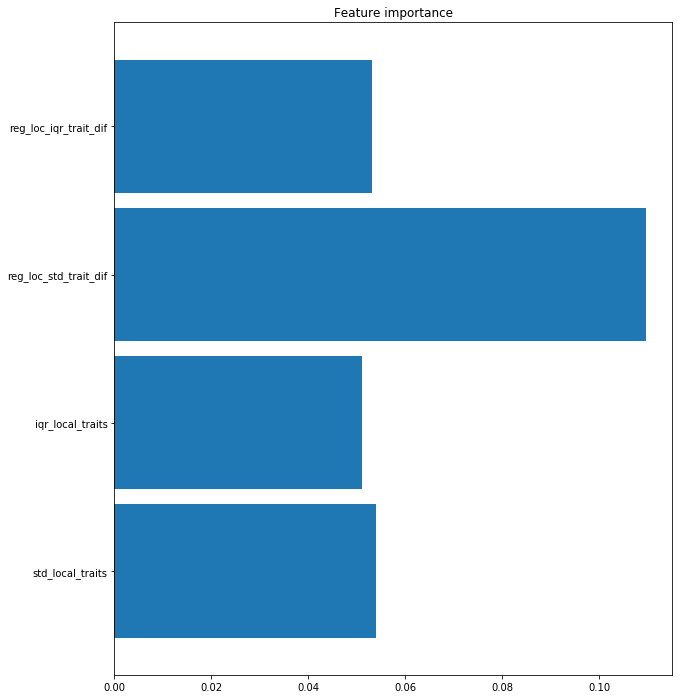

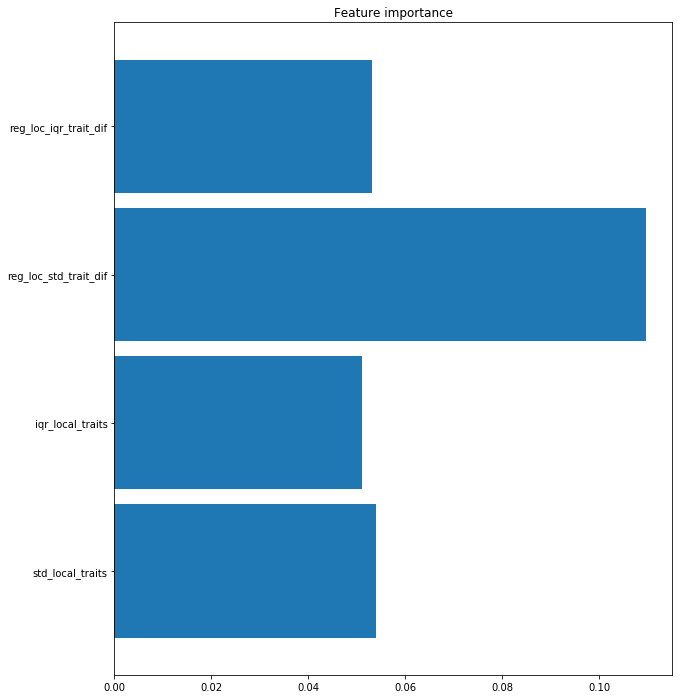

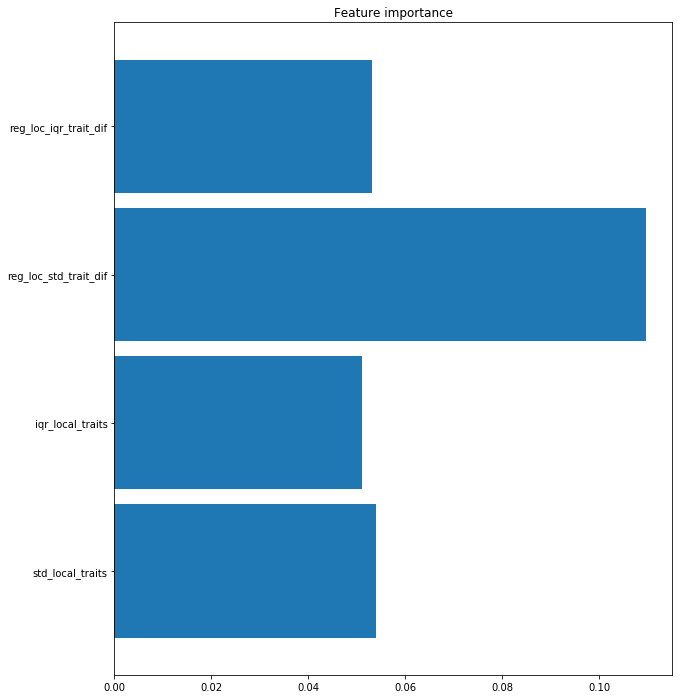

In [30]:
simfile = "/home/iovercast/Continuosity/MESS/analysis/figure5-sims/fig5_sims/SIMOUT.txt"

## This just creates the Classifier. Feels goofy to pass in the m_df twice, but that's what we've got rn.
cla = MESS.inference.Classifier(empirical_df=sl_df, simfile=simfile, algorithm="rf",\
                                metacommunity_traits=metacommunity_traits)
for isl, df in zip(["San_Cristobal", "Santa_Cruz", "Isabela"],\
                    [sl_df, sc_df, is_df]):
    if not os.path.exists(isl): os.mkdir(isl)
    cla.set_data(df)
    est, proba = cla.predict(select_features=True, param_search=True, quick=False, verbose=True)
    cla.dump(outfile="{}/{}_classifier.mdl".format(isl, isl))
    cla.plot_feature_importance()
    display(isl, est, proba)
    display(cla.feature_importances())

array([<matplotlib.axes._subplots.AxesSubplot object at 0x2aab4a08a610>],
      dtype=object)

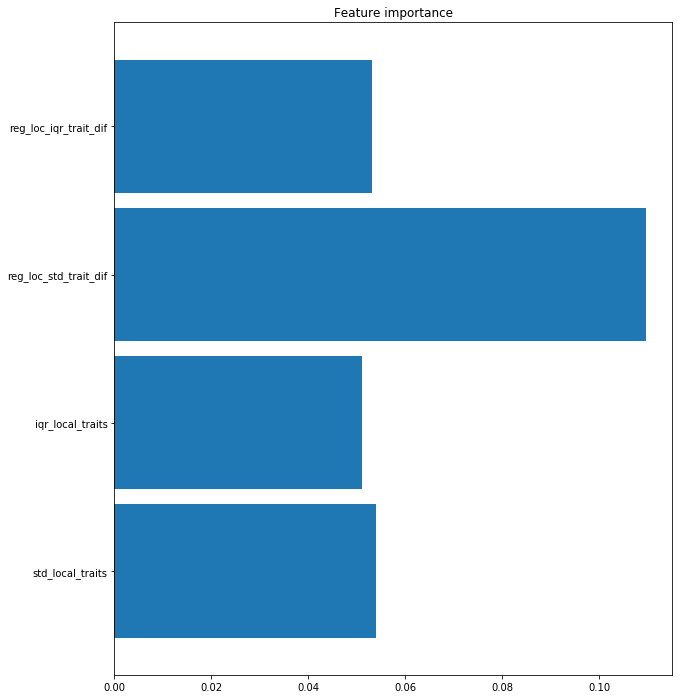

In [31]:
cla.plot_feature_importance()

## Estimate parameters for each of the 3 most speciose islands

In [ ]:
rgr = MESS.inference.Regressor(empirical_df=sl_df, simfile=simfile, target_model="filtering",\
                               algorithm="rfq", metacommunity_traits=metacommunity_traits)
for isl, df in zip(["San_Cristobal", "Santa_Cruz", "Isabela"],\
                [sl_df, sc_df, is_df]):
    print("Estimate params for {}".format(n))
    rgr.set_data(df)
    est = rgr.predict(select_features=True, param_search=True, quick=False, verbose=True)
    rgr.dump(outfile="{}/{}_regressor.mdl".format(isl, isl))
    display(isl, est, rgr.feature_importances())


Estimate params for Isabela
Predict() started: 2019-06-13 16:34:14.911619
Selecting features:
  alpha	['pi_h1', 'pi_h4', 'mean_pi', 'skewness_pi', 'median_pi', 'iqr_pi', 'std_local_traits', 'kurtosis_local_traits', 'iqr_local_traits', 'reg_loc_std_trait_dif', 'reg_loc_kurtosis_trait_dif', 'reg_loc_iqr_trait_dif', 'SGD_0']
  ecological_strength	['std_pi', 'std_local_traits', 'iqr_local_traits', 'kurtosis_regional_traits', 'iqr_regional_traits', 'reg_loc_mean_trait_dif', 'reg_loc_std_trait_dif', 'reg_loc_kurtosis_trait_dif', 'reg_loc_median_trait_dif', 'reg_loc_iqr_trait_dif']
  J	['S', 'pi_h1', 'pi_h2', 'pi_h3', 'pi_h4', 'mean_pi', 'std_pi', 'iqr_local_traits', 'skewness_regional_traits', 'kurtosis_regional_traits', 'iqr_regional_traits', 'reg_loc_skewness_trait_dif', 'reg_loc_kurtosis_trait_dif', 'reg_loc_median_trait_dif', 'reg_loc_iqr_trait_dif', 'SGD_0']
  m	['S', 'pi_h1', 'pi_h2', 'pi_h3', 'pi_h4', 'mean_pi', 'std_pi', 'skewness_local_traits', 'kurtosis_local_traits', 'median_local

In [ ]:
_ = rgr.plot_feature_importance(figsize=(10, 20))

## Posterior predictive simulations
Here we're reloading the regressor from the file so if the notebook dies we can still run the PPC without having to retrain the model.

San_Cristobal
New simulations will be appended to SIMOUT.txt in './ppc'. Use `force=True` to overwrite.
  [####################] 100% Performing simulations 
Calculating PCs and plotting
Santa_Cruz
New simulations will be appended to SIMOUT.txt in './ppc'. Use `force=True` to overwrite.
  [####################] 100% Performing simulations 
Calculating PCs and plotting
Isabela
New simulations will be appended to SIMOUT.txt in './ppc'. Use `force=True` to overwrite.
  [####################] 100% Performing simulations 
Calculating PCs and plotting


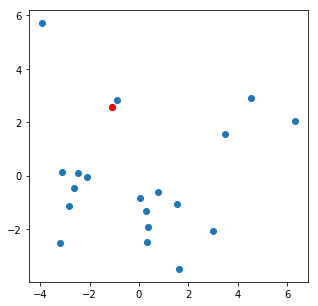

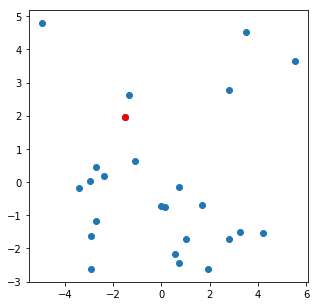

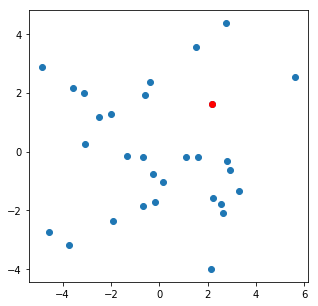

In [25]:
for isl, df in zip(["San_Cristobal", "Santa_Cruz", "Isabela"],\
                [sl_df, sc_df, is_df]):
    print(isl)
    rgr = MESS.inference.Ensemble.load("{}/{}_regressor.mdl".format(isl, isl))
    est = rgr.empirical_pred
    MESS.inference.posterior_predictive_check(empirical_df=df, nsims=5, parameter_estimates=est, verbose=True)